BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: ...
BPM: 52
BPM: 52
BPM: 52
BPM: 52
BPM: 52
BPM: 52
BPM: 52


c:\Users\dang0\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dang0\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

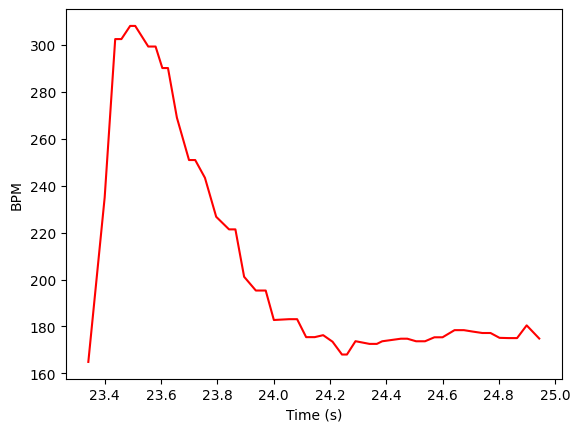

: 

In [ ]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Define global variables
EPOCH = time.time()  # Starting time for the video capture
SIGNIFICANT_BPM_CHANGE = 5  # Threshold for significant BPM change to detect increases or decreases

# Initialize BPM tracking variables
hr_times = []
hr_values = []
avg_bpms = []

# OpenCV Face Cascade Classifier (for detecting faces)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to extract heart rate (BPM) from cheekL and cheekR signals
def get_bpm_tells(cheekL, cheekR, fps, bpm_chart):
    global hr_times, hr_values, avg_bpms
    global ax, line, peakpts

    # Only use the green channel (index 1) for heart rate extraction
    cheekLgreen = np.average(cheekL[:, :, 1])  # Green channel
    cheekRgreen = np.average(cheekR[:, :, 1])  # Green channel
    current_time = time.time() - EPOCH
    hr_times.append(current_time)
    hr_values.append(cheekLgreen + cheekRgreen)

    # Limit the size of hr_times and hr_values to avoid excessive memory usage
    if len(hr_times) > 300:  # Keep data for approximately 10 seconds
        hr_times = hr_times[-300:]
        hr_values = hr_values[-300:]

    # Plot BPM chart if bpm_chart is set to True
    if bpm_chart:
        line.set_data(hr_times, hr_values)
        ax.relim()
        ax.autoscale()

    # Find peaks in the heart rate signal
    peaks, _ = find_peaks(hr_values,
                          prominence=0.5,  # Minimum prominence of peaks
                          distance=fps * 0.5)  # Approximate distance for ~1 Hz heart rate
    peak_times = [hr_times[i] for i in peaks]

    # Calculate the BPM based on peak intervals
    if len(peak_times) > 1:
        intervals = np.diff(peak_times)
        bpms = 60 / intervals  # Convert intervals to BPM
        recent_avg_bpm = int(np.mean(bpms[(bpms > 50) & (bpms < 150)]))  # Filter realistic BPM values
    else:
        recent_avg_bpm = 0

    bpm_display = f"BPM: {recent_avg_bpm if recent_avg_bpm > 0 else '...'}"
    return bpm_display

# Function to get cheek regions from a face
def extract_cheek_regions(frame, face_cascade):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        cheekL = frame[y + h // 4: y + 3 * h // 4, x: x + w // 2]  # Left cheek region
        cheekR = frame[y + h // 4: y + 3 * h // 4, x + w // 2: x + w]  # Right cheek region
        return cheekL, cheekR
    return None, None

# Initialize webcam
cap = cv2.VideoCapture(0)

# Create a figure for plotting the heart rate
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-')
peakpts, = ax.plot([], [], 'bo')
ax.set_xlim(0, 10)  # Set X axis range (time)
ax.set_ylim(50, 150)  # Set Y axis range (BPM)
plt.xlabel('Time (s)')
plt.ylabel('BPM')

# Get FPS from webcam
fps = cap.get(cv2.CAP_PROP_FPS) or 30  # Fallback to 30 if not available

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        break

    # Extract cheek regions (simulated with face detection)
    cheekL, cheekR = extract_cheek_regions(frame, face_cascade)

    if cheekL is not None and cheekR is not None:
        bpm_display = get_bpm_tells(cheekL, cheekR, fps, bpm_chart=True)
        print(bpm_display)

        # Display the BPM on the frame
        cv2.putText(frame, bpm_display, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Heart Rate Detection', frame)

    # Check for quit key (press 'q' to quit)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

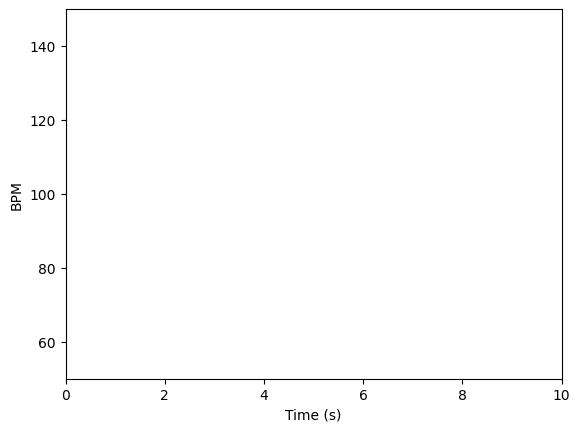

In [ ]:
import cv2
import numpy as np
import time
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import csv

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

# Define facial landmark indices for ROI
forehead_indices = [107, 66, 69, 109, 10, 338, 299, 296, 336, 9]
left_cheek_indices = [118, 119, 100, 126, 209, 49, 129, 203, 205, 50]
right_cheek_indices = [347, 348, 329, 355, 429, 279, 358, 423, 425, 280]

# Initialize variables
EPOCH = time.time()
hr_times = []
hr_values = []
buffer_size = 300  # Buffer size to hold data for 10 seconds at 30 FPS

# CSV File Setup
csv_file = "emotion_data.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Time", "Emotion", "Confidence"])

# Function to extract the average green channel value from ROI
def extract_roi_values(frame, landmarks, indices):
    h, w, _ = frame.shape
    values = []
    for idx in indices:
        x = int(landmarks[idx].x * w)
        y = int(landmarks[idx].y * h)
        if 0 <= x < w and 0 <= y < h:
            values.append(frame[y, x, 1])  # Green channel
    return np.mean(values) if values else 0

# Placeholder emotion detection logic
def detect_emotion(signal_value):
    # Simple logic for demonstration
    if signal_value < 20:
        return "Neutral", 0.8
    elif signal_value < 50:
        return "Happy", 0.9
    elif signal_value < 80:
        return "Sad", 0.85
    else:
        return "Angry", 0.7

# Capture video from webcam
cap = cv2.VideoCapture(0)
fps = cap.get(cv2.CAP_PROP_FPS) or 30

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Flip frame horizontally for a mirror effect
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process frame with MediaPipe Face Mesh
    result = face_mesh.process(rgb_frame)

    if result.multi_face_landmarks:
        landmarks = result.multi_face_landmarks[0].landmark

        # Extract green channel values for each region
        forehead_value = extract_roi_values(frame, landmarks, forehead_indices)
        left_cheek_value = extract_roi_values(frame, landmarks, left_cheek_indices)
        right_cheek_value = extract_roi_values(frame, landmarks, right_cheek_indices)

        # Combine regions and calculate heart rate signal
        signal_value = forehead_value + left_cheek_value + right_cheek_value

        # Detect emotion based on signal value
        emotion, confidence = detect_emotion(signal_value)

        # Record the data with timestamp
        current_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - EPOCH))
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([current_time, emotion, round(confidence, 2)])

        # Display emotion and confidence on frame
        cv2.putText(frame, f"Emotion: {emotion}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame
    cv2.imshow('Emotion Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
